In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sn
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.colorbar
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False

To assess the potential effects of cytokines on the downstream cellular interactions, we used CellphoneDB (version 3.1.0) to identify the ligand-receptor based communication between decidual EVTs and their surrounding populations including uNK cells, macrophages, perivascular cells, stromal cells, and endothelial cells.

Prepare the input for running CellPhoneDB. This was done in R.

In [ ]:
##R script
library(Seurat)
sj <- readRDS('nature_2018_10X_seurat_res.RDS')
sj <- subset(sj, subset=annotation %in% c('dNK1', 'dNK2', 'dNK3', 'EVT', 'dM1', 'dM2', 'dM3', 'dP1', 'dP2', 'dS1', 'dS2', 'dS3', 'Endo (m)'))
sj <- subset(sj, subset=location=='Decidua')
meta_info <- data.frame(Cell=colnames(sj), cell_type=sj$annotation, row.names=colnames(sj), stringsAsFactors=F)
counts <- expm1(sj$RNA@data)
write.table(meta_info, file='cellphonedb_input_meta.txt', quote=F, sep='\t', row.names=T, col.names=T)
write.table(counts, file='cellphonedb_input_counts.txt', quote=F, sep='\t', row.names=T, col.names=T)

CellPhoneDB was then run using the CLI version.

In [ ]:
!cellphonedb method statistical_analysis cellphonedb_input_meta.txt cellphonedb_input_counts.txt --counts-data hgnc_symbol --output-path cellphonedb_stat_res

Visualize selected ligand-receptor pairs.

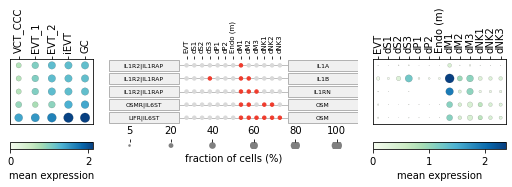

In [2]:
##decidual cell types from Vento-Tormo et al., Nature, 2018
ctys1 = ['EVT', 'dS1', 'dS2', 'dS3', 'dP1', 'dP2', 'Endo (m)', 'dM1', 'dM2', 'dM3', 'dNK1', 'dNK2', 'dNK3']
adata1 = sc.read('../../../../fluffy/analyses/new_data_4_samples/nature_2018_10X.h5ad')
adata1 = adata1.raw.to_adata()
adata1.obs['celltype'] = adata1.obs['annotation'].astype(str)
ind = (adata1.obs['location']=='Decidua')
adata1 = adata1[ind, :].copy()
mat1 = [np.log1p(np.expm1(adata1[adata1.obs['celltype']==i, :].X).mean(0)) for i in ctys1]
mat1 = np.row_stack(mat1)
mat1 = pd.DataFrame(mat1, index=ctys1, columns=adata1.var_names).T
pct1 = [(adata1[adata1.obs['celltype']==i, :].X > 0).mean(0) for i in ctys1]
pct1 = np.row_stack(pct1)
pct1 = pd.DataFrame(pct1, index=ctys1, columns=adata1.var_names).T

##EVT cell subtypes from Arutyunyan et al., Nature, 2023
ctys2 = ['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT', 'GC']
adata2 = sc.read('../../../adata_P13_trophoblast_raw_counts_in_raw_normlog_counts_in_X_for_download.h5ad')
adata2.obs['celltype'] = adata2.obs['final_annot_all_troph_corrected'].astype(str)
mat2 = [np.log1p(adata2[adata2.obs['celltype']==i, :].X.expm1().mean(0)) for i in ctys2]
mat2 = np.row_stack(mat2)
mat2 = pd.DataFrame(mat2, index=ctys2, columns=adata2.var_names).T
pct2 = [(adata2[adata2.obs['celltype']==i, :].X > 0).mean(0) for i in ctys2]
pct2 = np.row_stack(pct2)
pct2 = pd.DataFrame(pct2, index=ctys2, columns=adata2.var_names).T

##summarise and select ligand-receptor pairs
cpdb_pval = pd.read_csv('../../../cellphonedb_stat_res/pvalues.txt', sep='\t', index_col=0)
cpdb_p1 = cpdb_pval[['partner_a', 'partner_b', 'gene_a', 'gene_b'] + [f'EVT|{i}' for i in ctys1]]
cpdb_p2 = cpdb_pval[['partner_b', 'partner_a', 'gene_b', 'gene_a'] + [f'{i}|EVT' for i in ctys1]]
cpdb_p2.columns = cpdb_p1.columns
ind1 = (cpdb_p1.iloc[:, 4:].min(1) < 0.05)
ind2 = (cpdb_p2.iloc[:, 4:].min(1) < 0.05)
cpdb_p1 = cpdb_p1[ind1]
cpdb_p2 = cpdb_p2[ind2]
cpdb_pval = cpdb_p1.append(cpdb_p2)

cplx = pd.read_csv('~/.cpdb/releases/v4.0.0/data/complex_input.csv', index_col=0)
gid = pd.read_csv('~/.cpdb/releases/v4.0.0/data/gene_input.csv', index_col=1).iloc[:, :2].drop_duplicates()
gid['uniprot'] = gid.index.copy()
gid.drop_duplicates(subset='uniprot', keep='first', inplace=True)
for i in range(4):
    ind = ~cplx.iloc[:, i].isna()
    cplx.loc[ind, f'uniprot_{i+1}'] = gid.loc[cplx.loc[ind, f'uniprot_{i+1}'], 'gene_name'].values
for i in ['a', 'b']:
    ind = cpdb_pval[f'partner_{i}'].str.startswith('complex:')
    cpdb_pval.loc[ind, f'gene_{i}'] = cplx.loc[cpdb_pval[ind][f'partner_{i}'].str.replace('complex:', '').values].iloc[:, :4].apply(lambda x: '|'.join(x.dropna().tolist()), axis=1).values

up_ggs = pd.read_csv('../../../EVT_invivo_invitro_DE_gene_overlap_up.csv', header=None)[0].values
down_ggs = pd.read_csv('../../../EVT_invivo_invitro_DE_gene_overlap_down.csv', header=None)[0].values
ggs = np.concatenate([up_ggs, down_ggs])
ga = cpdb_pval['gene_a'].str.split('\\|', expand=True)
ind = (ga[0].isin(ggs) | ga[1].isin(ggs) | ga[2].isin(ggs)).values
cpdb_pval = cpdb_pval[ind]
cpdb_pval.sort_values(by='gene_a', inplace=True)
select_r = ['IL1R2', 'OSMR', 'LIFR']
cpdb_pval = pd.concat([cpdb_pval[cpdb_pval['gene_a'].str.contains(i)] for i in select_r], axis=0)
select_l = ['IL1A', 'IL1B', 'IL1RN', 'OSM']
cpdb_pval = pd.concat([cpdb_pval[cpdb_pval['gene_b'].str.contains(i)] for i in select_l], axis=0)

##visualize the ligand-receptor profiles
pmat1 = cpdb_pval['gene_b'].str.split('\\|', expand=True).apply(lambda x: mat1.loc[x[~x.isnull()]].mean(0), axis=1)
ppct1 = cpdb_pval['gene_b'].str.split('\\|', expand=True).apply(lambda x: pct1.loc[x[~x.isnull()]].mean(0), axis=1)
pmat2 = cpdb_pval['gene_a'].str.split('\\|', expand=True).apply(lambda x: mat2.loc[x[~x.isnull()]].mean(0), axis=1)
ppct2 = cpdb_pval['gene_a'].str.split('\\|', expand=True).apply(lambda x: pct2.loc[x[~x.isnull()]].mean(0), axis=1)

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(8, 2.5),
                        gridspec_kw=dict(width_ratios=[1, 3, 1.6], height_ratios=[1, 0.1], left=0.07, right=0.93, bottom=0.2, top=0.7, wspace=0.1, hspace=0.5))
##expression of receptors in EVT cells
ax = axs[0, 0]
ax.set_xlim(0, pmat2.shape[1])
ax.set_ylim(0, pmat2.shape[0])
ax.set_xticks(np.arange(pmat2.shape[1]) + 0.5)
ax.set_xticklabels(pmat2.columns, rotation=90)
ax.tick_params(axis='y', left=False, labelleft=False)
x1 = np.tile(np.arange(pmat2.shape[1]) + 0.5, pmat2.shape[0])
y1 = np.repeat(np.arange(pmat2.shape[0], 0, -1) - 0.5, pmat2.shape[1])
vmax = np.percentile(pmat2, 99)
ax.scatter(x1, y1, c=pmat2.values.flatten(), s=ppct2.values.flatten()*100,
           edgecolor='black', linewidths=0.1, cmap='GnBu',
           vmin=0, vmax=vmax)
norm = Normalize(vmin=0, vmax=vmax)
cmap = plt.get_cmap('GnBu')
mappable = ScalarMappable(norm=norm, cmap=cmap)
matplotlib.colorbar.Colorbar(ax=axs[1, 0], mappable=mappable, orientation='horizontal')
axs[1, 0].set_xlabel('mean expression')

##significance of the interactions
ax = axs[0, 1]
ax.set_xlim(1, len(ctys1) + 20)
ax.set_ylim(0, pmat2.shape[0])
x1 = np.tile(np.arange(11, len(ctys1) + 11), pmat2.shape[0])
y1 = np.repeat(np.arange(pmat2.shape[0], 0, -1) - 0.5, len(ctys1))
cls = np.repeat('#d9d9d9', len(x1))
ind = (cpdb_pval.iloc[:, 4:].values < 0.05).flatten()
cls[ind] = '#ef3b2c'
ax.scatter(x1, y1, color=cls, s=12, zorder=3)
y2 = np.arange(pmat2.shape[0], 0, -1) - 0.5
for i in range(pmat2.shape[0]):
    ax.add_patch(Rectangle(xy=(1, y2[i]-0.4), width=9, height=0.8, facecolor='#f0f0f0', edgecolor='0.7'))
    ax.text(5.5, y2[i], cpdb_pval['gene_a'].values[i], fontsize=6, horizontalalignment='center', verticalalignment='center')
    ax.add_patch(Rectangle(xy=(len(ctys1) + 11, y2[i]-0.4), width=9, height=0.8, facecolor='#f0f0f0', edgecolor='0.7'))
    ax.text(len(ctys1) + 15.5, y2[i], cpdb_pval['gene_b'].values[i], fontsize=6, horizontalalignment='center', verticalalignment='center')
    ax.hlines(y2[i], xmin=10, xmax=len(ctys1)+11, color='gray', linewidth=0.5, linestyle='solid', zorder=0)
ax.set_xticks(np.arange(11, len(ctys1) + 11))
ax.set_xticklabels(ctys1, rotation=90, fontdict=dict(fontsize=7))
ax.tick_params(axis='y', left=False, labelleft=False)
for pp in ['right', 'top', 'left', 'bottom']:
    ax.spines[pp].set_visible(False)

size_range = np.array([0.05, 0.2, 0.4, 0.6, 0.8, 1.0])
ax = axs[1, 1]
ax.set_xlim(0, len(size_range))
ax.set_ylim(-0.05, 0.05)
ax.set_xlabel('fraction of cells (%)')
ax.scatter(np.arange(len(size_range)) + 0.5, np.repeat(0, len(size_range)),
           s=size_range * 100, color='gray', edgecolor='black', linewidths=0.1)
ax.set_xticks(np.arange(len(size_range)) + 0.5)
ax.set_xticklabels([np.round(x * 100).astype(int) for x in size_range])
ax.tick_params(axis='y', left=False, labelleft=False)
for pp in ['right', 'top', 'left', 'bottom']:
    ax.spines[pp].set_visible(False)
    
ax = axs[0, 2]
ax.set_xlim(0, pmat1.shape[1])
ax.set_ylim(0, pmat1.shape[0])
ax.set_xticks(np.arange(pmat1.shape[1]) + 0.5)
ax.set_xticklabels(pmat1.columns, rotation=90)
ax.tick_params(axis='y', left=False, labelleft=False)
x1 = np.tile(np.arange(pmat1.shape[1]) + 0.5, pmat1.shape[0])
y1 = np.repeat(np.arange(pmat1.shape[0], 0, -1) - 0.5, pmat1.shape[1])
vmax = np.percentile(pmat1, 99)
ax.scatter(x1, y1, c=pmat1.values.flatten(), s=ppct1.values.flatten()*100,
           edgecolor='black', linewidths=0.1, cmap='GnBu',
           vmin=0, vmax=vmax)
norm = Normalize(vmin=0, vmax=vmax)
cmap = plt.get_cmap('GnBu')
mappable = ScalarMappable(norm=norm, cmap=cmap)
matplotlib.colorbar.Colorbar(ax=axs[1, 2], mappable=mappable, orientation='horizontal')
axs[1, 2].set_xlabel('mean expression')
plt.show()